In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [103]:
class LSTM_Cell(tf.keras.layers.AbstractRNNCell):

    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)

        self.units = units

        self.forget_gate_layer = tf.keras.layers.Dense(units=units, activation="sigmoid")
        self.input_gate_layer = tf.keras.layers.Dense(units=units, activation="sigmoid")
        self.output_gate_layer = tf.keras.layers.Dense(units=units, activation="sigmoid")
       
        self.cell_state_candiate_layer = tf.keras.layers.Dense(units=units, activation="tanh")

    @property
    def state_size(self):
        return [tf.TensorShape(self.units), tf.TensorShape(self.units)]
    
    @property
    def output_size(self):
        return [tf.TensorShape(self.units), tf.TensorShape(self.units)]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        # hidden_state, cell_state
        return [tf.zeros(shape=(batch_size, self.units)), tf.zeros(shape=(batch_size, self.units))]
    

    def call(self, inputs, states):
        prev_hidden_state = states[0]
        prev_cell_state = states[1]

        concat_hidden_inputs = tf.concat([prev_hidden_state, inputs], axis=-1)

        #
        # Preparing
        #

        f = self.forget_gate_layer(concat_hidden_inputs)
        i = self.input_gate_layer(concat_hidden_inputs)

        cell_state_candiate = self.cell_state_candiate_layer(concat_hidden_inputs)

        #
        # Update cell state
        #

        cell_state = f * prev_cell_state +  i * cell_state_candiate

        #
        # Determinating hidden state and output
        #

        o = self.output_gate_layer(concat_hidden_inputs)

        hidden_state = o * tf.math.tanh(cell_state)

        return hidden_state, [hidden_state, cell_state]

In [104]:
class RNNModel(tf.keras.Model):
    def __init__(self, sequence_length, hidden_length):
        super().__init__()
        
        self.cell = LSTM_Cell(units=hidden_length)
        
        self.rnn_layer = tf.keras.layers.RNN(self.cell, return_sequences=False, unroll=True)
        
        self.output_layer = tf.keras.layers.Dense(1)

        self.metrics_list = [tf.keras.metrics.Mean(name="loss")]

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
    
    @tf.function
    def call(self, sequence, training=False):
        x = self.rnn_layer(sequence)
        x = self.output_layer(x)
        return x

    
    @tf.function
    def train_step(self, data):
        """
        Standard train_step method
        :param data: 
        :return: 
        """

        sequence, label = data
        with tf.GradientTape() as tape:
            output = self.call(sequence, training=True)
            loss = self.compiled_loss(label, output, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        """
        Standard test_step method
        :param data: 
        :return: 
        """

        sequence, label = data
        output = self.call(sequence, training=False)
        loss = self.compiled_loss(label, output, regularization_losses=self.losses)

        self.metrics[0].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

In [119]:
def create_dataset(sequence_length):
    X_train = tf.cast(np.random.randint(0, 10, (10000, sequence_length)), tf.float32)
    X_train = tf.expand_dims(X_train, axis=-1)
    y_train = tf.reduce_sum(X_train[:, :, 0:2], axis=1)  # Addition der ersten beiden Zahlen in jeder Sequenz
    y_train = tf.cast(y_train, tf.float32)

    X_val = tf.cast(np.random.randint(0, 10, (5000, sequence_length)), tf.float32)
    X_val = tf.expand_dims(X_val, axis=-1)
    y_val = tf.reduce_sum(X_val[:, :, 0:2], axis=1)  # Addition der ersten beiden Zahlen in jeder Sequenz
    y_val = tf.cast(y_val, tf.float32)
    
    return X_train, y_train, X_val, y_val

Training für Sequenzlänge: 50


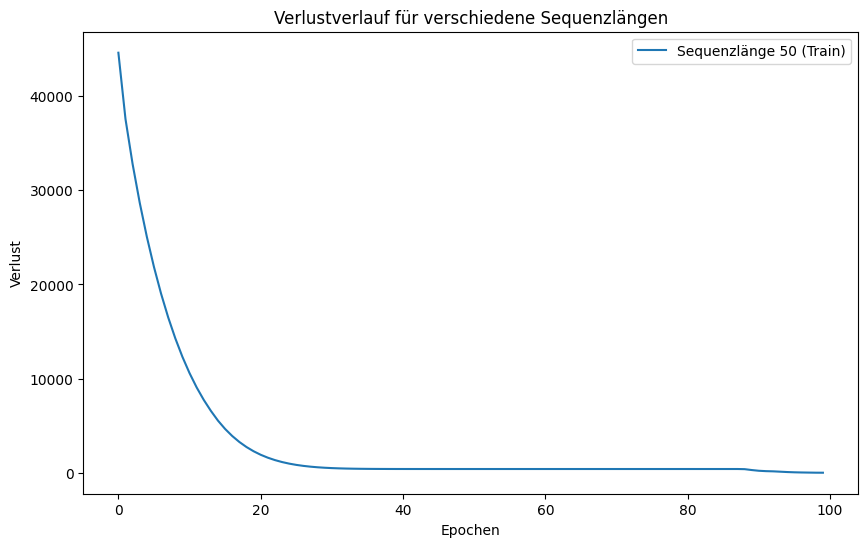

20.333059310913086


In [128]:
def train_and_plot_loss(sequence_lengths):
    histories = {}  # Ein Dictionary zum Speichern der Verlaufshistorien
    
    for seq_length in sequence_lengths:
        print(f"Training für Sequenzlänge: {seq_length}")
        
        # Erstellen des Datensets für die aktuelle Sequenzlänge
        X_train, y_train, X_val, y_val = create_dataset(seq_length)
        
        # Modell erstellen
        model = RNNModel(sequence_length=seq_length, hidden_length=128)
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-3,
            decay_steps=1000,
            decay_rate=0.9
        )
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
        
        # Modell kompilieren
        model.compile(optimizer=optimizer, loss='mse')
        
        # Modell trainieren
        history = model.fit(X_train, y_train, 
                            epochs=100, 
                            batch_size=100, 
                            validation_data=(X_val, y_val),
                            verbose=0)  # Verbosity auf 0 setzen, um den Trainingsfortschritt nicht auszugeben
        
        histories[seq_length] = history  # Verlaufshistorie für die aktuelle Sequenzlänge speichern
    
    # Plotten des Verlustverlaufs für jede Sequenzlänge
    plt.figure(figsize=(10, 6))
    for seq_length, history in histories.items():
        plt.plot(history.history['loss'], label=f"Sequenzlänge {seq_length} (Train)")
        # plt.plot(history.history['val_loss'], label=f"Sequenzlänge {seq_length} (Val)")

    plt.title('Verlustverlauf für verschiedene Sequenzlängen')
    plt.xlabel('Epochen')
    plt.ylabel('Verlust')
    plt.legend()
    plt.show()
    
    return histories[sequence_lengths[0]]  # Rückgabe der Verlaufshistorie für die erste Sequenzlänge

# Trainieren und Plotten des Verlustverlaufs für Sequenzlängen 3, 10 und 20
history = train_and_plot_loss(sequence_lengths=[50])

print(history.history['loss'][-1])

In [126]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plottet den Trainings- und Validierungsverlust über die Epochen.
    
    :param history: Das History-Objekt, das von der fit-Methode zurückgegeben wird.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    
    plt.plot(epochs, train_loss, 'r', label='Trainingsverlust')
    plt.plot(epochs, val_loss, 'b', label='Validierungsverlust')
    plt.title('Trainings- und Validierungsverlust')
    plt.xlabel('Epochen')
    plt.ylabel('Verlust')
    plt.legend()
    plt.ylim(0,3000)
    plt.show()


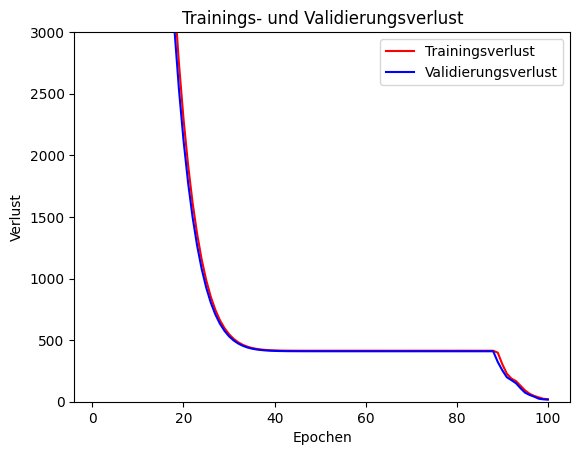

[44590.31640625, 37546.875, 32773.5859375, 28670.134765625, 25057.0625, 21856.4453125, 19018.71875, 16503.748046875, 14279.26953125, 12315.5087890625, 10587.1171875, 9070.861328125, 7745.41796875, 6581.62255859375, 5542.634765625, 4662.560546875, 3915.312744140625, 3282.01416015625, 2747.47412109375, 2298.8388671875, 1924.6904296875, 1615.0428466796875, 1360.479248046875, 1153.0537109375, 985.50830078125, 851.4151000976562, 745.274658203125, 662.0267333984375, 597.5468139648438, 548.155517578125, 510.7225646972656, 482.7827453613281, 462.2121887207031, 447.2867126464844, 436.62176513671875, 429.1343078613281, 423.9412841796875, 420.4139709472656, 418.0538330078125, 416.49920654296875, 415.49969482421875, 414.8668212890625, 414.4845275878906, 414.2538757324219, 414.1169128417969, 414.0361633300781, 413.9825744628906, 413.9628601074219, 413.9450378417969, 413.9360656738281, 413.93878173828125, 413.9476318359375, 413.9365539550781, 413.941162109375, 413.9448547363281, 413.93511962890625, 

In [129]:
plot_loss(history)

print(history.history['loss'][-100:])